In [1]:
import sys
sys.path.append('/workspace/src/')
from labeling_setup import *
from database.database_setup import *
from database.model import Base, Document, Table
from dotenv import dotenv_values

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy import text

import random 
import pandas as pd
import fitz 
import time
import os
import json
import pickle
from io import StringIO
from tabulate import tabulate

from ipywidgets import RadioButtons, Button, VBox, Label, Layout
from IPython.display import display
from IPython.display import clear_output
from IPython.display import Image

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# env file with bd credentials
db_vals = dotenv_values("/workspace/src/.env")

In [3]:
# setup uf database connections
db_tables = "cord19docling"
db_pdf = "cord19plus"

engine = create_engine(f"postgresql+psycopg2://{db_vals['USER']}:{db_vals['PASSWORD']}@{db_vals['ADDRESS']}:{db_vals['PORT']}/{db_tables}", echo=False)
session = Session(engine)
Base.metadata.create_all(engine)

engine_pdf = create_engine(f"postgresql+psycopg2://{db_vals['USER']}:{db_vals['PASSWORD']}@{db_vals['ADDRESS']}:{db_vals['PORT']}/{db_pdf}", echo=False)
session_pdf = Session(engine_pdf)
Base.metadata.create_all(engine_pdf)

In [4]:
cord19_topics = pickle.load(open("topics.pkl", "rb"))

In [5]:
all_tids = session.query(Table.ir_tab_id).all()

In [6]:
random_tids = [a[0] for a in random.choices(all_tids, k=1000)]

In [7]:
session.rollback()

In [8]:
from pprint import pprint

In [9]:
print(match_topic_table(random_tids[22], 42, session, cord19_topics)[1]["df"].to_markdown(tablefmt="grid"))

+----+-----------------------------------------+--------------+-------------------------+--------------------------+-------------------------------------+--------------------+-----------------------+-------------------------------------+
|    | Study or subgroup.                      | Pressure.N   | Volume.N                | Mean Dif- ference.(SE)   | Mean Difference.IV, Fixed, 95% CI   | Mean Difference.   | Weight.               | Mean Difference.IV, Fixed, 95% CI   |
+====+=========================================+==============+=========================+==========================+=====================================+====================+=======================+=====================================+
|  0 | Tuggey 2005                             | 0            | 0                       | 1.2 (0.97)               |                                     |                    | 100%                  | 1.2[-0.7,3.1]                       |
+----+-----------------------------------------+

In [10]:
curr_doc = -1

# Run Cells from Here downwards for each albeling iteration

In [11]:
curr_doc = curr_doc+1
print(f"Labeling random table {curr_doc}.")

Labeling random table 0.


In [12]:
session_pdf.rollback()

In [13]:
table_df, t_name, t_caption, image_filename, doi, tid =  get_rating_data(random_tids[curr_doc], session, session_pdf)
print(f"parsed table name: {t_name}")
print(f"parsed table caption: {t_caption}")
table_df

None



,,Imaging Part N =20.N (%).,Therapeutic Part N =8.Arm A.N,Therapeutic Part N =8.Arm B.N
0,No,2 (10%),0,1
1,Prior Radiotherapy,,,
2,Yes,15 (75.0%),3,3
3,No,5 (25.0%),0,2
4,Chemotherapy with Doxorubicin,,,
5,"Yes, in monotherapy",5 (25.0%),1,2
6,"Yes, associated",15 (75.0%),2,3
7,Chromosomal translocation site,,,
8,missing,1,0,0
9,SSX1,11 (57.9%),1,4


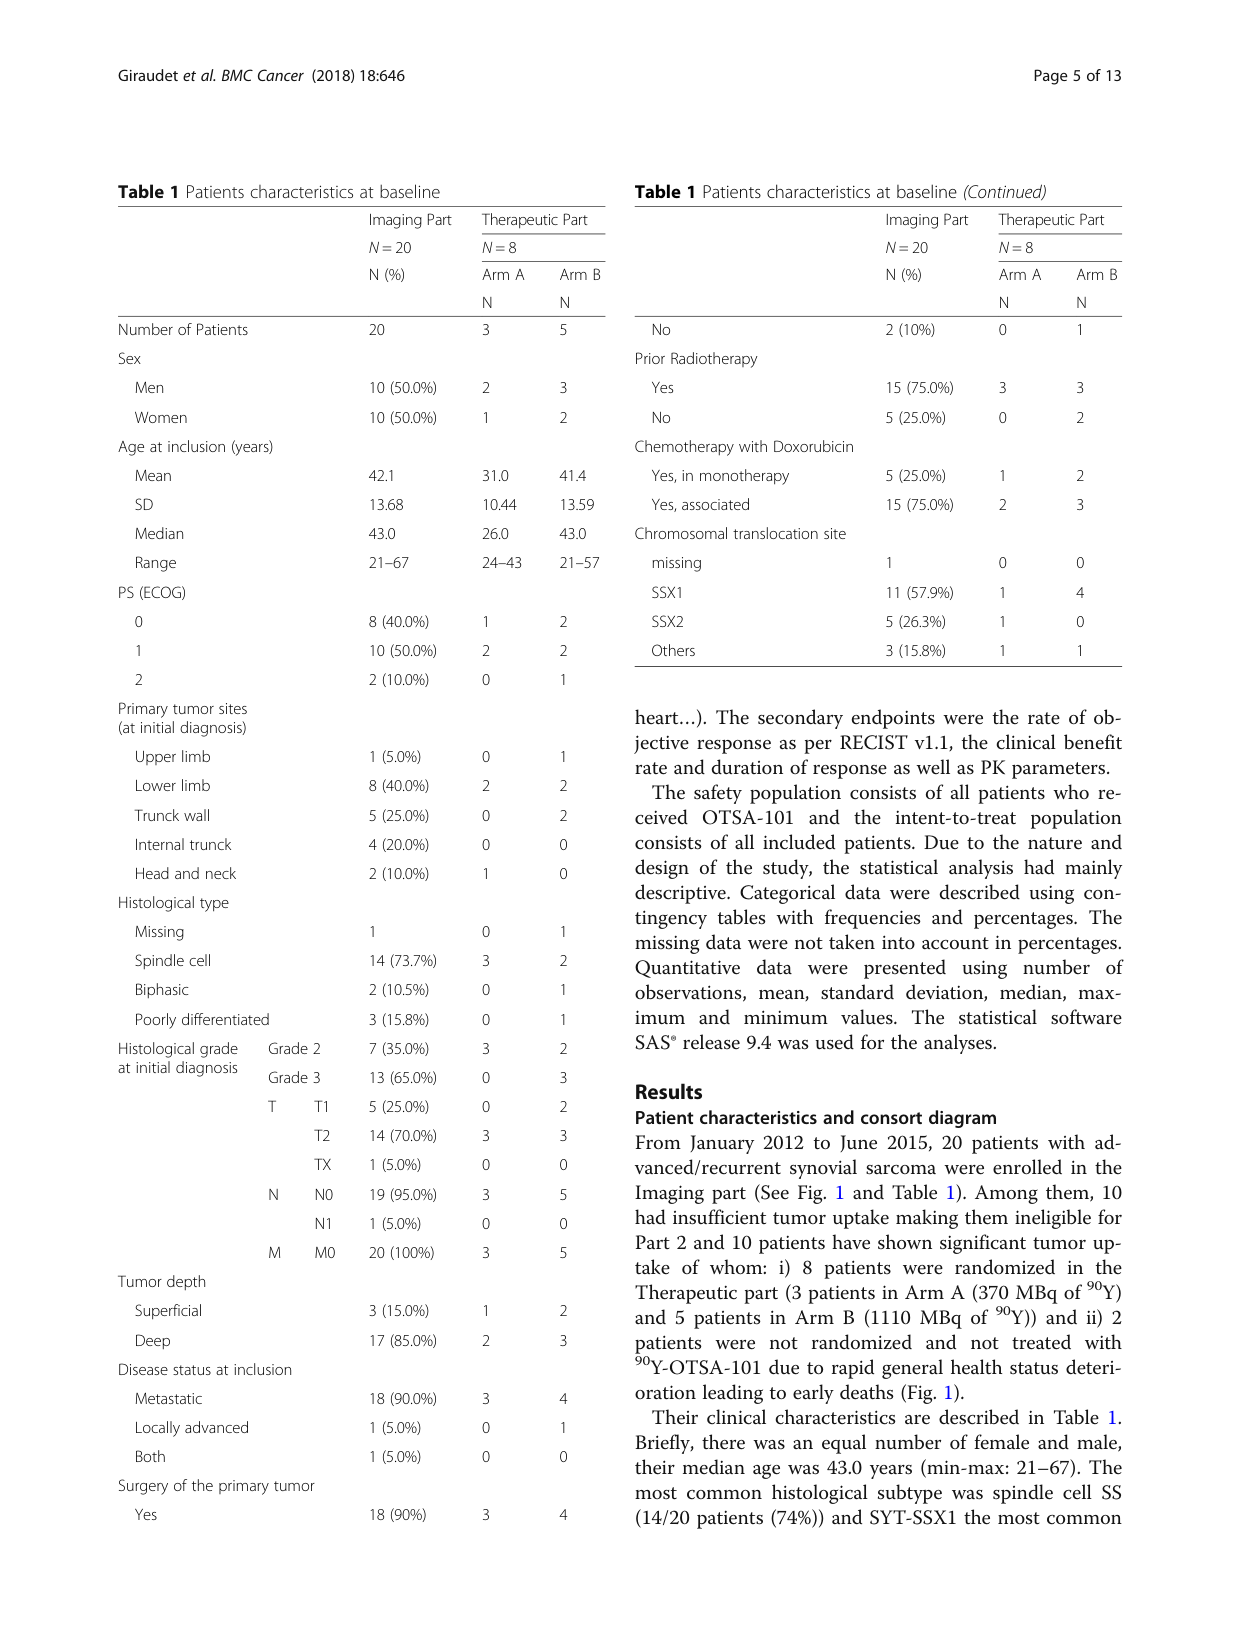

In [14]:
Image(filename=image_filename)

In [15]:
log_table_feedback(doi, tid)


# Relevance Assessment

In [18]:
top_data, tab_data = match_topic_table(tid, 5, session, cord19_topics)
tab_data["df"]

,,Imaging Part N =20.N (%).,Therapeutic Part N =8.Arm A.N,Therapeutic Part N =8.Arm B.N
0,No,2 (10%),0,1
1,Prior Radiotherapy,,,
2,Yes,15 (75.0%),3,3
3,No,5 (25.0%),0,2
4,Chemotherapy with Doxorubicin,,,
5,"Yes, in monotherapy",5 (25.0%),1,2
6,"Yes, associated",15 (75.0%),2,3
7,Chromosomal translocation site,,,
8,missing,1,0,0
9,SSX1,11 (57.9%),1,4


In [17]:
rel_table_topic(top_data, tab_data, context=True, log_file='relass_log.json')